# Singular Value Decomposition of CLM PPE

In [1]:
import numpy as np
from scipy.io import netcdf as nc
import matplotlib.pyplot as plt

In [2]:
var = ["GPP", "LHF"]
nvar = len(var)

Get landfrac from an existing PPE simulation (constant throughout simulations)

In [3]:
f_lf = nc.netcdf_file("/glade/scratch/kdagon/archive/hydro_ensemble_LHC_1/lnd/hist/hydro_ensemble_LHC_1.clm2.h0.0016-01.nc",'r', mmap=False)
lf = f_lf.variables['landfrac']
landfrac = lf[:]

Mask landfrac to account for netcdf FillValues

In [4]:
import numpy.ma as ma
landfrac_mask = ma.masked_where(landfrac > 1e34, landfrac) # sufficiently large to mask FillValues (~1e36)

Read in outputdata (PPE results) including obs mask

In [5]:
f = nc.netcdf_file("outputdata/outputdata_"+var[0]+"_forSVD_100.nc",'r',mmap=False)
X = f.variables[var[0]]
mask = f.variables['datamask']
d = X[:]
m = mask[:]
nens=d.shape[0]
nlat=d.shape[1]
nlon=d.shape[2]

Mask landfrac (again!) to match obs mask

In [6]:
landfrac_mask_obs = ma.masked_where(m==0, landfrac_mask)

Perform SVD

In [7]:
i,j = np.nonzero(landfrac_mask_obs)
dr = d[:,i,j]
print(dr.shape)
U,s,Vh = np.linalg.svd(dr, full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(100, 721)
(100, 100) (100,) (100, 721)


Sanity check - reconstruction

In [8]:
print(np.allclose(dr, np.dot(U*s, Vh)))
smat = np.diag(s)
print(np.allclose(dr, np.dot(U, np.dot(smat, Vh))))

True
True


Calculate % variance explained

In [9]:
prop_var = s**2/np.sum(s**2)
print(100*np.sum(prop_var)) # should be ~100%
print(100*np.sum(prop_var[0:3])) # first 3 modes, total variance
print(prop_var[0:3]) # first 3 modes, individual variance

99.99999403953552
98.0880081653595
[0.83406484 0.1348919  0.01192334]


Truncate at 3 modes (>95% variance)

In [10]:
nmodes = 3

Reconstruct spatial maps

In [11]:
Vhmap = np.full((nens,nlat,nlon),np.nan)
Vhmap[:,i,j] = Vh
Vhmap.shape

(100, 46, 72)

Plot histograms (U vector)

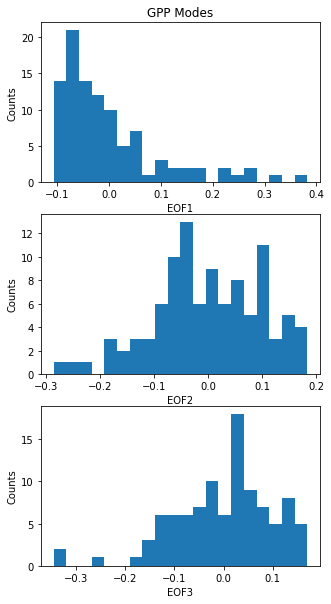

In [12]:
fig, axs = plt.subplots(nmodes, 1, figsize=(5,10))
axs = axs.ravel()
for j in range(nmodes):
    axs[j].hist(U[:,j], bins=20)
    axs[j].set_xlabel("EOF"+str(j+1))
    axs[j].set_ylabel("Counts");
axs[0].set_title(var[0]+" Modes");

Plot "ensemble"-series (U vector)

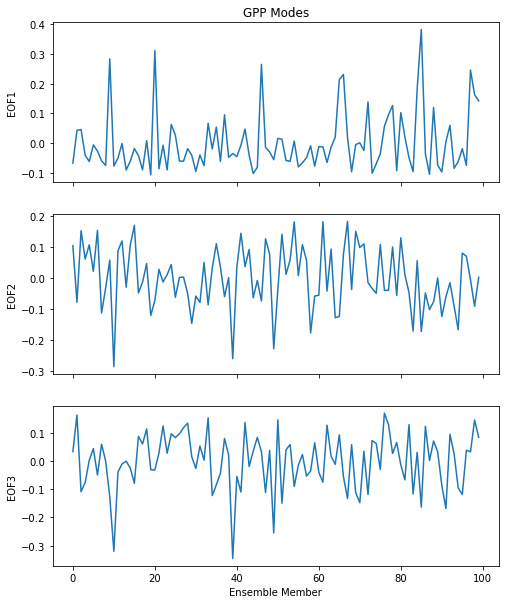

In [13]:
fig, axs = plt.subplots(nmodes, 1, figsize=(8,10), sharex=True)
axs = axs.ravel()
for j in range(nmodes):
    axs[j].plot(U[:,j])
    axs[j].set_ylabel("EOF"+str(j+1))
    if j == nmodes-1:
            axs[j].set_xlabel("Ensemble Member");  
axs[0].set_title(var[0]+" Modes");

Use xarray for plotting gridded output

In [14]:
import xarray as xr

Read in PPE output again using xarray

In [15]:
PPE_forSVD = xr.open_dataset("outputdata/outputdata_"+var[0]+"_forSVD_100.nc")

Get coordinates

In [16]:
PPE_forSVD_da = PPE_forSVD[var[0]]
PPE_forSVD_da.coords

Coordinates:
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0

Convert Vhmaps to data array using xarray

In [17]:
Vhmap_xr = xr.DataArray(Vhmap, coords = PPE_forSVD_da.coords, dims=PPE_forSVD_da.dims)

Need cartopy for mapping

In [18]:
import cartopy.crs as ccrs
import cartopy
from cartopy.util import add_cyclic_point
import matplotlib as mpl

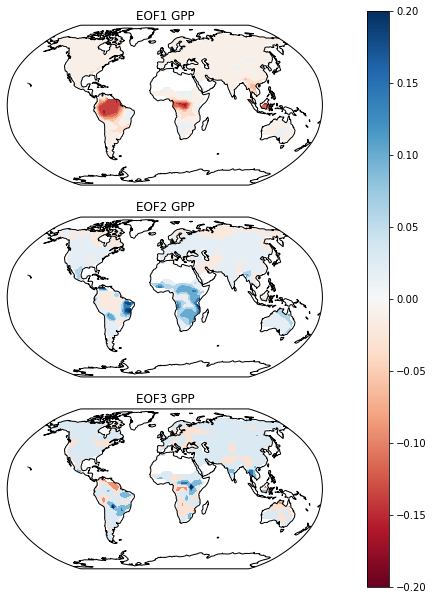

In [19]:
fig, axs = plt.subplots(nmodes, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Robinson()})
axs = axs.ravel()
for j in range(nmodes):
    Vhmap_mode = Vhmap_xr[j]
    field, lon = add_cyclic_point(Vhmap_mode, coord=Vhmap_mode.lon)
    lat = Vhmap_mode.lat
    cf = axs[j].contourf(lon, lat, field, cmap='RdBu',transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2);
    #cf = axs[j].pcolormesh(lon, lat, field, cmap='RdBu',transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2);
    #print(cf.get_clim()) # Sanity check color scale consistent on all panels
    axs[j].coastlines()
    axs[j].set_global()
    axs[j].set_title('EOF'+str(j+1)+' GPP')

# adding colorbar
cb_ax = fig.add_axes([0.7, 0.1, 0.02, 0.8])
cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm)

#plt.savefig("PPE_EOFmaps_GPP_3modes.pdf")

Save what you need for GPP

In [20]:
U_GPP = U
Vhmap_GPP = Vhmap_xr

Plotting unweighted Vh maps

In [21]:
area = f_lf.variables['area']
areas = area[:]
areas.shape
grid_area_m = areas*10**6 # km^2 to m^2

Mask cell areas to account for fillvalues over ocean

In [22]:
area_mask = ma.masked_where(grid_area_m > 1e34, grid_area_m) # sufficiently large to mask FillValues (~1e36)

Generate area weights (dimensionless)

In [23]:
arwt = area_mask/area_mask.max()

Divide Vh maps by area weighting

In [24]:
Vhmap_GPP_unwgt = Vhmap_GPP/arwt

Plot unweighted, equal area Vh maps

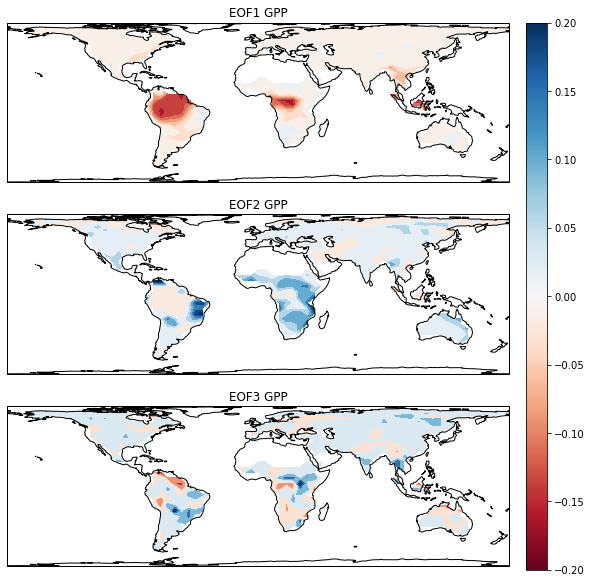

In [25]:
fig, axs = plt.subplots(nmodes, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.LambertCylindrical()})
axs = axs.ravel()
for j in range(nmodes):
    Vhmap_mode = Vhmap_GPP_unwgt[j]
    field, lon = add_cyclic_point(Vhmap_mode, coord=Vhmap_mode.lon)
    lat = Vhmap_mode.lat
    cf = axs[j].contourf(lon, lat, field, cmap='RdBu', transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2);
    axs[j].coastlines()
    axs[j].set_global()
    axs[j].set_title('EOF'+str(j+1)+' GPP')

# add axes with specified left, bottom, width, height
cb_ax = fig.add_axes([0.76, 0.12, 0.02, 0.76])

# more colorbar options (e.g., set bounds)
cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm)

Read in parameter values for some additional plotting

In [26]:
inputdata = np.load(file="lhc_100.npy", allow_pickle=True)

In [27]:
# List of input variables
in_vars = ['medlynslope','dleaf','kmax','fff','dint','baseflow_scalar']
nparam = len(in_vars)

Read in observed modes (generated in SVD.py)

In [28]:
Fobs = [np.load("obs/obs_"+v+"_SVD_3modes.npy") for v in var]

Visualize ensemble distribution in 2D mode space, each mode combination

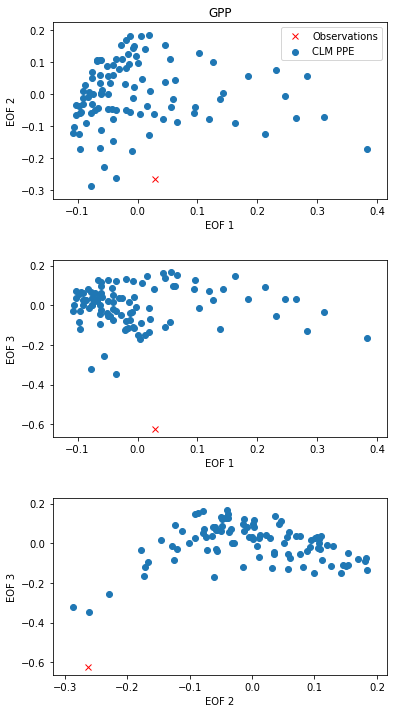

In [29]:
fig, axs = plt.subplots(nmodes, figsize=(6, 12))
# Mode 2 vs. Mode 1
axs[0].scatter(U_GPP[:,0],U_GPP[:,1], label="CLM PPE")
axs[0].plot(Fobs[0][:,0],Fobs[0][:,1], 'xr', label='Observations')
axs[0].set_xlabel("EOF 1")
axs[0].set_ylabel("EOF 2")
axs[0].set_title(var[0])
axs[0].legend()
# Mode 3 vs. Mode 1
axs[1].scatter(U_GPP[:,0],U_GPP[:,2], label="CLM PPE")
axs[1].plot(Fobs[0][:,0],Fobs[0][:,2], 'xr', label='Observations')
axs[1].set_xlabel("EOF 1")
axs[1].set_ylabel("EOF 3")
# Mode 3 vs Mode 2
axs[2].scatter(U_GPP[:,1],U_GPP[:,2], label="CLM PPE")
axs[2].plot(Fobs[0][:,1],Fobs[0][:,2], 'xr', label='Observations')
axs[2].set_xlabel("EOF 2")
axs[2].set_ylabel("EOF 3")

plt.subplots_adjust(hspace=0.35)
#plt.legend();

Visualize parameters in 2D mode space (first two modes only)

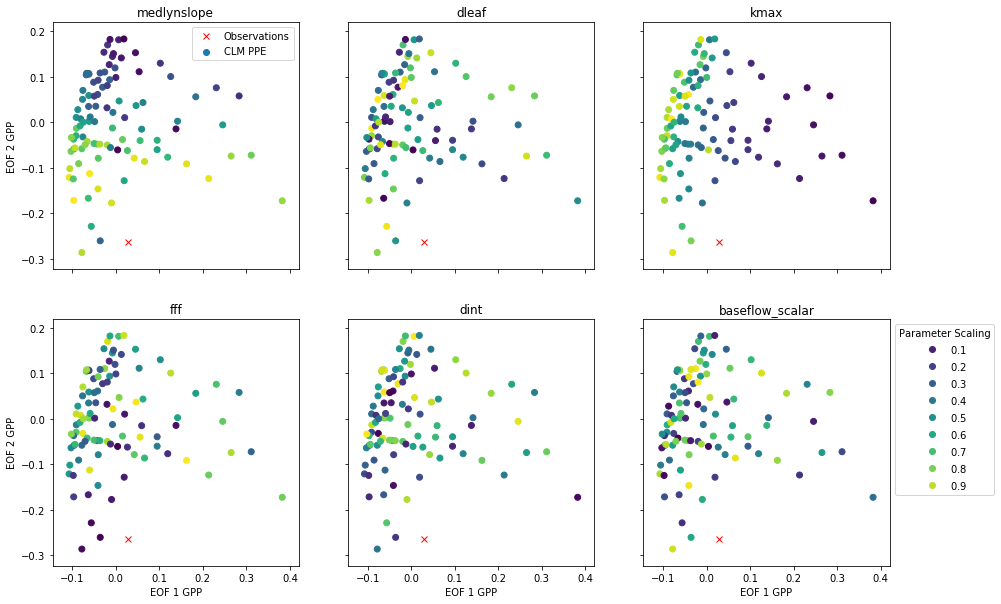

In [30]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axs = axs.ravel()
for i in range(nparam):
    scatter=axs[i].scatter(U_GPP[:,0],U_GPP[:,1], label="CLM PPE", c=inputdata[:,i])
    axs[i].plot(Fobs[0][:,0],Fobs[0][:,1], 'xr', label='Observations')
    if i > 2:
        axs[i].set_xlabel("EOF 1 "+var[0])
    if i == 0 or i == 3:
        axs[i].set_ylabel("EOF 2 "+var[0])
    axs[i].set_title(in_vars[i])
    if i == 0:
        axs[i].legend()
    if i == nparam-1:
        axs[i].legend(*scatter.legend_elements(),bbox_to_anchor=(1, 1),title="Parameter Scaling")
#plt.savefig("EOF2vsEOF1_GPP_byparam_withobs.pdf")

Regressing U-vectors onto parameter matrix

In [31]:
from scipy import stats

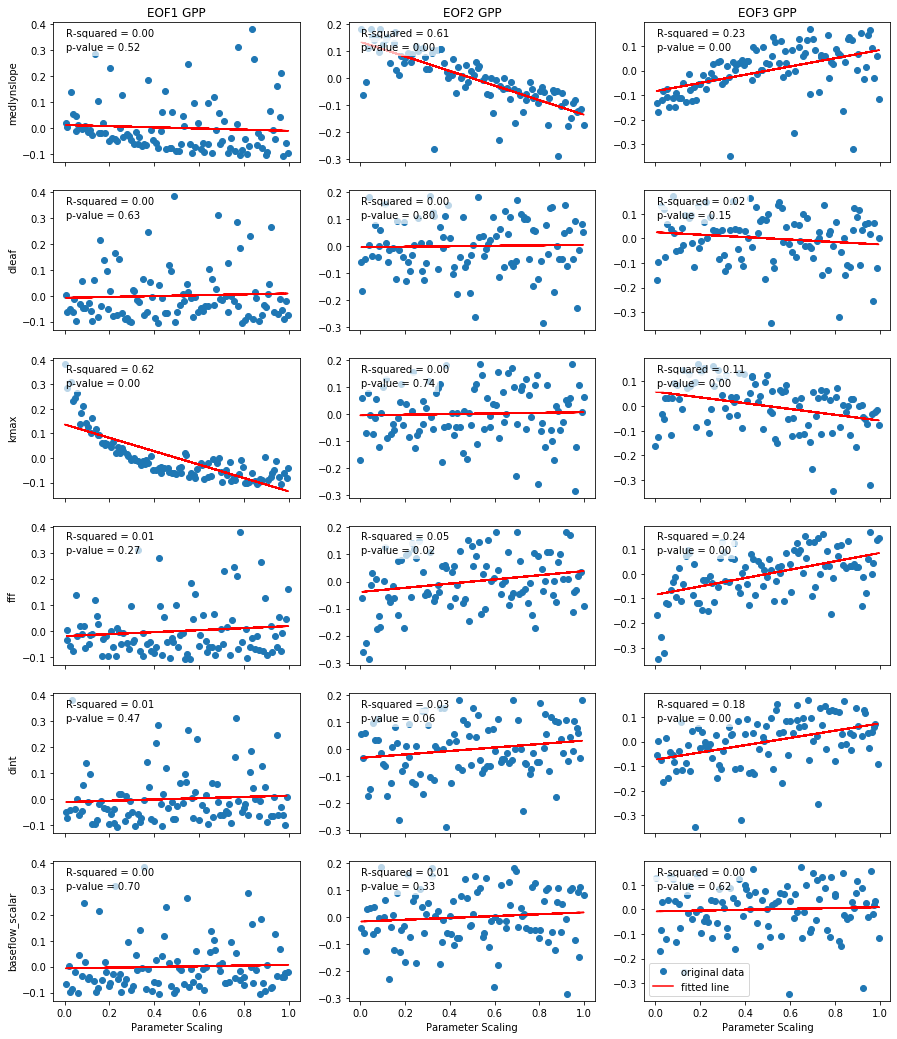

In [32]:
fig, axs = plt.subplots(nparam, nmodes, figsize=(15,18), sharex=True)
#axs = axs.ravel()
for j in range(nmodes):
    for i in range(nparam):
        x=inputdata[:,i]
        y=U_GPP[:,j]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x.astype(float),y)
        axs[i,j].plot(x, y, 'o', label='original data')
        axs[i,j].plot(x, intercept + slope*x, 'r', label='fitted line')
        axs[i,j].text(0.05, 0.9, 'R-squared = %0.2f' % r_value**2, transform=axs[i,j].transAxes, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        axs[i,j].text(0.05, 0.8, 'p-value = %0.2f' % p_value, transform=axs[i,j].transAxes, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        if i == 0:
            axs[i,j].set_title('EOF'+str(j+1)+' GPP')
        if j == 0:
            axs[i,j].set_ylabel(in_vars[i])
        if i == nparam-1:
            axs[i,j].set_xlabel('Parameter Scaling')
plt.legend();  
#plt.savefig("Parameter_regressions_EOF1-3_GPP.pdf")

### Now for LHF

In [33]:
f = nc.netcdf_file("outputdata/outputdata_"+var[1]+"_forSVD_100.nc",'r',mmap=False)
X = f.variables[var[1]]
mask = f.variables['datamask']
d = X[:]
m = mask[:]
#print(m.shape)
nens=d.shape[0]
nlat=d.shape[1]
nlon=d.shape[2]
landfrac_mask_obs = ma.masked_where(m==0, landfrac_mask)
i_ind,j_ind = np.nonzero(landfrac_mask_obs)
dr = d[:,i_ind,j_ind]
print(dr.shape)
U,s,Vh = np.linalg.svd(dr, full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(100, 722)
(100, 100) (100,) (100, 722)


Calculate % variance explained

In [34]:
prop_var = s**2/np.sum(s**2)
print(100*np.sum(prop_var)) # should be ~100%
print(100*np.sum(prop_var[0:3])) # first 3 modes, total variance
print(prop_var[0:3]) # first 3 modes, individual variance

100.0
95.57834267616272
[0.7701996  0.12915632 0.05642754]


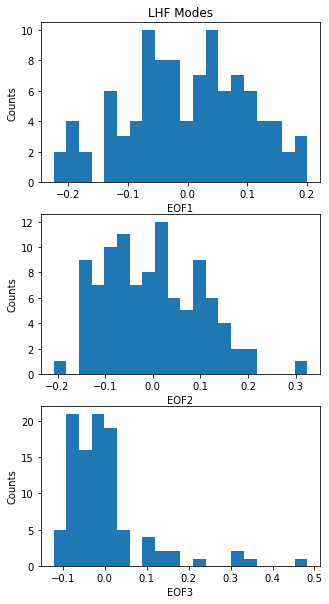

In [35]:
fig, axs = plt.subplots(nmodes, 1, figsize=(5,10))
axs = axs.ravel()
for j in range(nmodes):
    axs[j].hist(U[:,j], bins=20)
    axs[j].set_xlabel("EOF"+str(j+1))
    axs[j].set_ylabel("Counts");
axs[0].set_title(var[1]+" Modes");

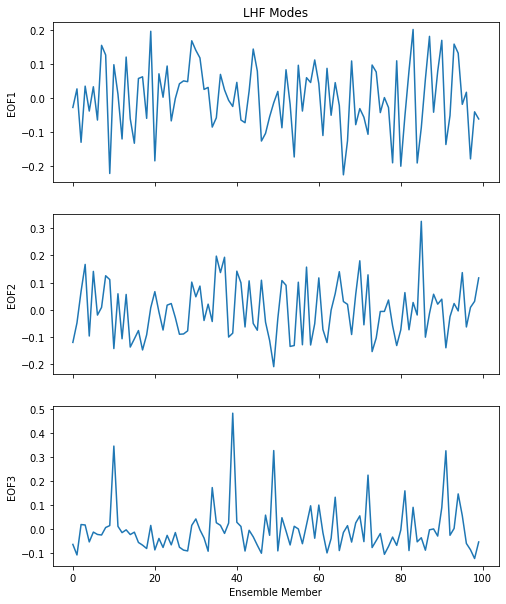

In [36]:
fig, axs = plt.subplots(nmodes, 1, figsize=(8,10), sharex=True)
axs = axs.ravel()
for j in range(nmodes):
    axs[j].plot(U[:,j])
    axs[j].set_ylabel("EOF"+str(j+1))
    if j == nmodes-1:
            axs[j].set_xlabel("Ensemble Member")
axs[0].set_title(var[1]+" Modes");
#plt.savefig("PPE_EOFseries_LHF_3modes.pdf")    

Reconstruct spatial maps

In [37]:
Vhmap = np.full((nens,nlat,nlon),np.nan)
Vhmap[:,i_ind,j_ind] = Vh
Vhmap.shape

(100, 46, 72)

In [38]:
PPE_forSVD = xr.open_dataset("outputdata/outputdata_"+var[1]+"_forSVD_100.nc")

In [39]:
PPE_forSVD_da = PPE_forSVD.LHF
PPE_forSVD_da.coords

Coordinates:
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0

In [40]:
Vhmap_xr = xr.DataArray(Vhmap, coords = PPE_forSVD_da.coords, dims=PPE_forSVD_da.dims)

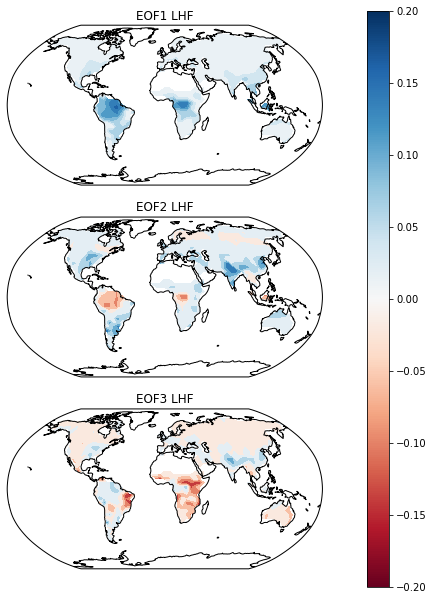

In [41]:
fig, axs = plt.subplots(nmodes, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Robinson()})
axs = axs.ravel()
for j in range(nmodes):
    Vhmap_mode = Vhmap_xr[j]
    field, lon = add_cyclic_point(Vhmap_mode, coord=Vhmap_mode.lon)
    lat = Vhmap_mode.lat
    cf = axs[j].contourf(lon, lat, field, cmap='RdBu',transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2);
    #cf = axs[j].pcolormesh(lon, lat, field, cmap='RdBu',transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2);
    #print(cf.get_clim())
    axs[j].coastlines()
    axs[j].set_global()
    axs[j].set_title('EOF'+str(j+1)+' LHF')

cb_ax = fig.add_axes([0.7, 0.1, 0.02, 0.8])

cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm)

#plt.savefig("PPE_EOFmaps_LHF_3modes.pdf")

Save what you need for LHF

In [42]:
U_LHF = U
Vhmap_LHF = Vhmap_xr

Divide Vh maps by area weighting

In [43]:
Vhmap_LHF_unwgt = Vhmap_LHF/arwt

Plot unweighted, equal area Vh maps

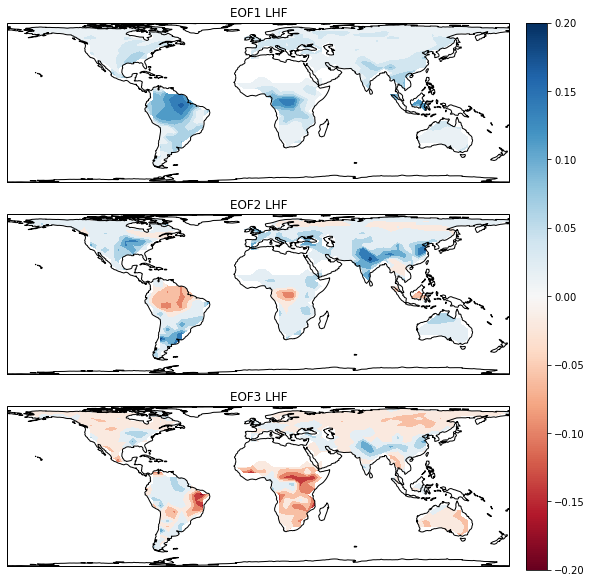

In [44]:
fig, axs = plt.subplots(nmodes, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.LambertCylindrical()})
axs = axs.ravel()
for j in range(nmodes):
    Vhmap_mode = Vhmap_LHF_unwgt[j]
    field, lon = add_cyclic_point(Vhmap_mode, coord=Vhmap_mode.lon)
    lat = Vhmap_mode.lat
    cf = axs[j].contourf(lon, lat, field, cmap='RdBu', transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2);
    axs[j].coastlines()
    axs[j].set_global()
    axs[j].set_title('EOF'+str(j+1)+' LHF')

# add axes with specified left, bottom, width, height
cb_ax = fig.add_axes([0.76, 0.12, 0.02, 0.76])

# more colorbar options (e.g., set bounds)
cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm)

Visualize ensemble distribution in 2D mode space, each mode combination

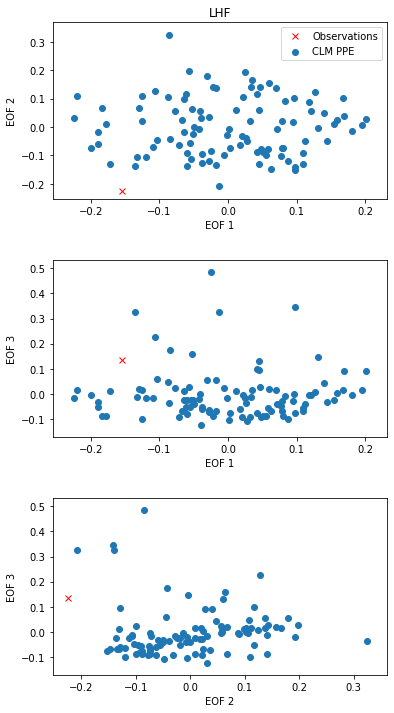

In [45]:
fig, axs = plt.subplots(nmodes, figsize=(6, 12))
# Mode 2 vs. Mode 1
axs[0].scatter(U_LHF[:,0],U_LHF[:,1], label="CLM PPE")
axs[0].plot(Fobs[1][:,0],Fobs[1][:,1], 'xr', label='Observations')
axs[0].set_xlabel("EOF 1")
axs[0].set_ylabel("EOF 2")
axs[0].set_title(var[1])
axs[0].legend()
# Mode 3 vs. Mode 1
axs[1].scatter(U_LHF[:,0],U_LHF[:,2], label="CLM PPE")
axs[1].plot(Fobs[1][:,0],Fobs[1][:,2], 'xr', label='Observations')
axs[1].set_xlabel("EOF 1")
axs[1].set_ylabel("EOF 3")
# Mode 3 vs Mode 2
axs[2].scatter(U_LHF[:,1],U_LHF[:,2], label="CLM PPE")
axs[2].plot(Fobs[1][:,1],Fobs[1][:,2], 'xr', label='Observations')
axs[2].set_xlabel("EOF 2")
axs[2].set_ylabel("EOF 3")

plt.subplots_adjust(hspace=0.35)
#plt.legend();

Visualize parameters in 2D mode space (first two modes only)

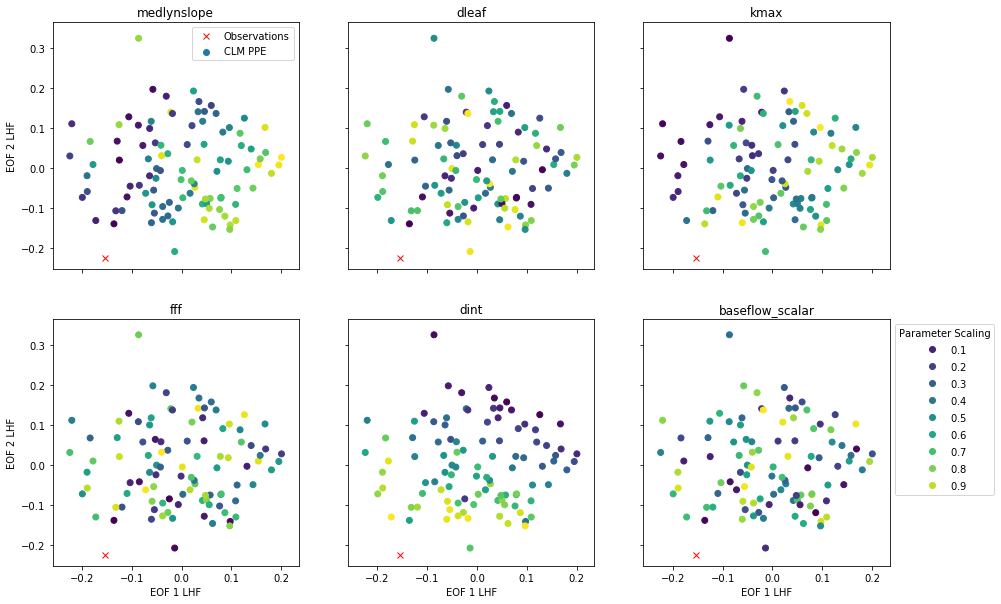

In [46]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axs = axs.ravel()
for i in range(nparam):
    scatter=axs[i].scatter(U_LHF[:,0],U_LHF[:,1], label="CLM PPE", c=inputdata[:,i])
    axs[i].plot(Fobs[1][:,0],Fobs[1][:,1], 'xr', label='Observations')
    if i > 2:
        axs[i].set_xlabel("EOF 1 "+var[1])
    if i == 0 or i == 3:
        axs[i].set_ylabel("EOF 2 "+var[1])
    axs[i].set_title(in_vars[i])
    if i == 0:
        axs[i].legend()
    if i == nparam-1:
        axs[i].legend(*scatter.legend_elements(),bbox_to_anchor=(1, 1),title="Parameter Scaling")
#plt.savefig("EOF2vsEOF1_LHF_byparam_withobs.pdf")

Regressing U-vectors onto parameter matrix

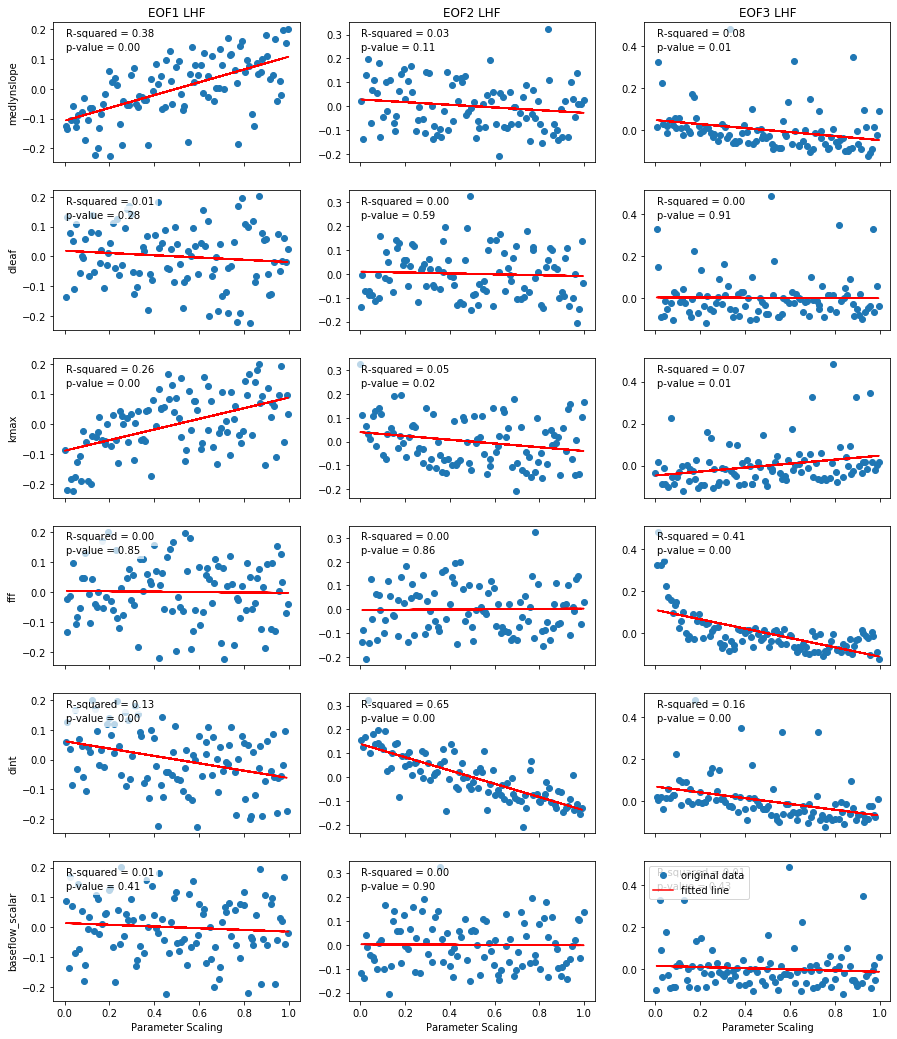

In [47]:
fig, axs = plt.subplots(nparam, nmodes, figsize=(15,18), sharex=True)
#axs = axs.ravel()
for j in range(nmodes):
    for i in range(nparam):
        x=inputdata[:,i]
        y=U_LHF[:,j]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x.astype(float),y)
        axs[i,j].plot(x, y, 'o', label='original data')
        axs[i,j].plot(x, intercept + slope*x, 'r', label='fitted line')
        axs[i,j].text(0.05, 0.9, 'R-squared = %0.2f' % r_value**2, transform=axs[i,j].transAxes, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        axs[i,j].text(0.05, 0.8, 'p-value = %0.2f' % p_value, transform=axs[i,j].transAxes, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        if i == 0:
            axs[i,j].set_title('EOF'+str(j+1)+' LHF')
        if j == 0:
            axs[i,j].set_ylabel(in_vars[i])
        if i == nparam-1:
            axs[i,j].set_xlabel('Parameter Scaling')
plt.legend();  
#plt.savefig("Parameter_regressions_EOF1-3_LHF.pdf")

## Plots with both GPP and LHF

First mode distributions and maps for GPP/LHF

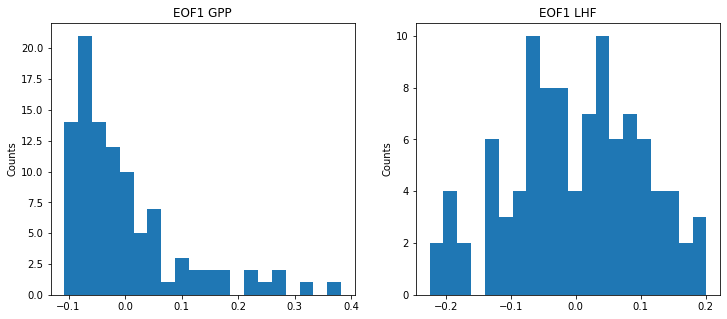

In [233]:
j=0 # mode 1
fig, axs = plt.subplots(1, nvar, figsize=(12,5))
#fig, axs = plt.subplots(2, nvar, figsize=(12, 5), subplot_kw={'projection': ccrs.Robinson()})
axs = axs.ravel()

axs[0].hist(U_GPP[:,j], bins=20)
#axs[0].set_xlabel("EOF"+str(j+1)+" GPP")
axs[0].set_ylabel("Counts")
axs[0].set_title("EOF"+str(j+1)+" GPP")

axs[1].hist(U_LHF[:,j], bins=20)
axs[1].set_title("EOF"+str(j+1)+" LHF")
axs[1].set_ylabel("Counts");

#plt.savefig("PPE_dists_EOF1_GPP_LHF.pdf")

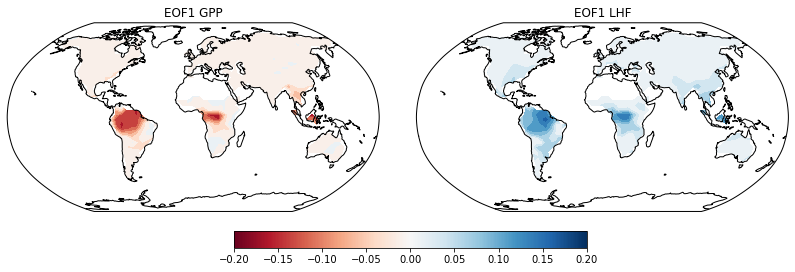

In [234]:
j=0 # mode 1
fig, axs = plt.subplots(1, nvar, figsize=(14, 6), subplot_kw={'projection': ccrs.Robinson()})
axs = axs.ravel()
# get_axes can also work
Vhmap_mode = Vhmap_GPP[j]
field, lon = add_cyclic_point(Vhmap_mode, coord=Vhmap_mode.lon)
lat = Vhmap_mode.lat
cf = axs[0].contourf(lon, lat, field, cmap='RdBu',transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2)
# contourf can be slow for big data
axs[0].coastlines()
axs[0].set_global()
axs[0].set_title('EOF'+str(j+1)+' GPP')

Vhmap_mode = Vhmap_LHF[j]
field, lon = add_cyclic_point(Vhmap_mode, coord=Vhmap_mode.lon)
lat = Vhmap_mode.lat
cf = axs[1].contourf(lon, lat, field, cmap='RdBu',transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2)
axs[1].coastlines()
axs[1].set_global()
axs[1].set_title('EOF'+str(j+1)+' LHF')

cb_ax = fig.add_axes([0.35, 0.2, 0.35, 0.04])
cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm, orientation='horizontal')

plt.subplots_adjust(wspace=0.1)

#plt.savefig("PPE_maps_EOF1_GPP_LHF.pdf")

Trying to get map plots and histograms on same panel plot

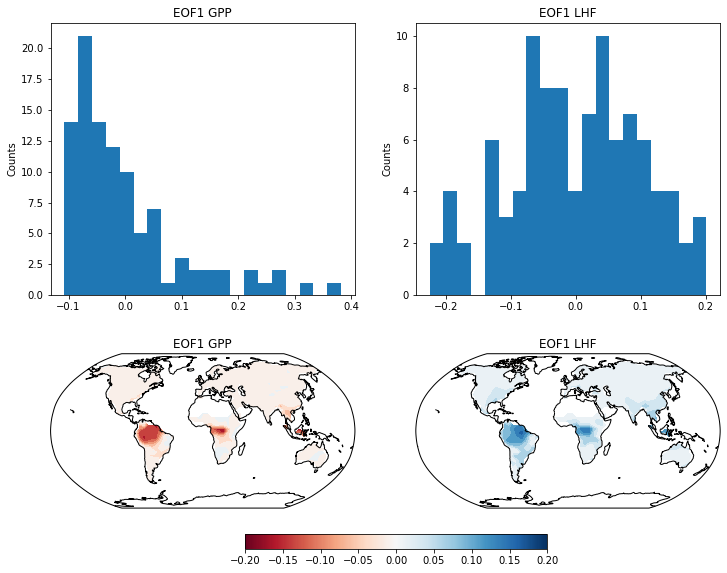

In [235]:
j=0 # mode 1
fig = plt.figure(figsize=(12,10))

ax3 = fig.add_subplot(2,2,1)
ax3.hist(U_GPP[:,j], bins=20)
#axs[0].set_xlabel("EOF"+str(j+1)+" GPP")
ax3.set_ylabel("Counts")
ax3.set_title("EOF"+str(j+1)+" GPP")

ax4 = fig.add_subplot(2,2,2)
ax4.hist(U_LHF[:,j], bins=20)
ax4.set_title("EOF"+str(j+1)+" LHF")
ax4.set_ylabel("Counts");

ax1 = fig.add_subplot(2,2,3,projection=ccrs.Robinson())
Vhmap_mode = Vhmap_GPP[j]
field, lon = add_cyclic_point(Vhmap_mode, coord=Vhmap_mode.lon)
lat = Vhmap_mode.lat
cf = ax1.contourf(lon, lat, field, cmap='RdBu',transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2)
# NOTE: contourf can be slow for big data
ax1.coastlines()
ax1.set_global()
ax1.set_title('EOF'+str(j+1)+' GPP')

ax2 = fig.add_subplot(2,2,4,projection=ccrs.Robinson())
Vhmap_mode = Vhmap_LHF[j]
field, lon = add_cyclic_point(Vhmap_mode, coord=Vhmap_mode.lon)
lat = Vhmap_mode.lat
cf = ax2.contourf(lon, lat, field, cmap='RdBu',transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2)
ax2.coastlines()
ax2.set_global()
ax2.set_title('EOF'+str(j+1)+' LHF')

cb_ax = fig.add_axes([0.35, 0.15, 0.35, 0.02])
cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm, orientation='horizontal')

plt.subplots_adjust(wspace=0.2,hspace=0)

#plt.savefig("PPE_dists_maps_EOF1_GPP_LHF.pdf")

Higher mode distributions and maps for GPP/LHF

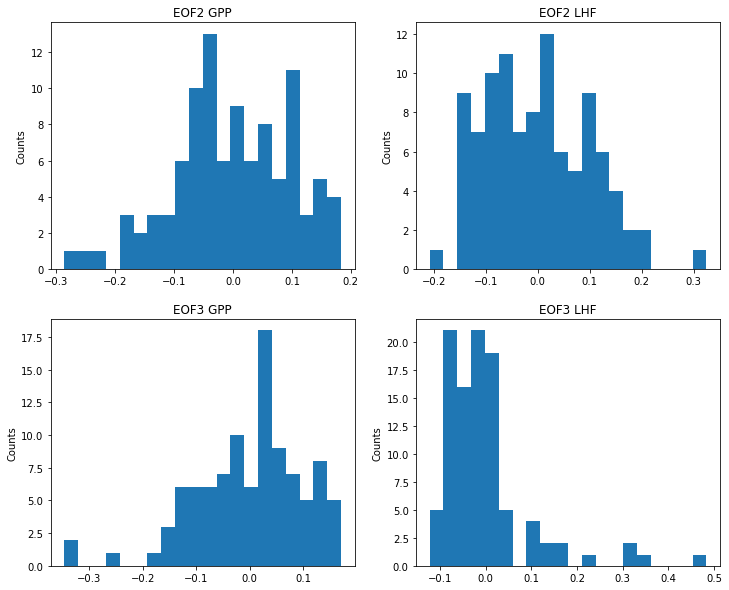

In [236]:
j=1 # mode 2
fig, axs = plt.subplots(2, nvar, figsize=(12,10))
axs = axs.ravel()

axs[0].hist(U_GPP[:,j], bins=20)
axs[0].set_ylabel("Counts")
axs[0].set_title("EOF"+str(j+1)+" GPP")

axs[1].hist(U_LHF[:,j], bins=20)
axs[1].set_title("EOF"+str(j+1)+" LHF")
axs[1].set_ylabel("Counts");

j=2 # mode 3
axs[2].hist(U_GPP[:,j], bins=20)
axs[2].set_ylabel("Counts")
axs[2].set_title("EOF"+str(j+1)+" GPP")

axs[3].hist(U_LHF[:,j], bins=20)
axs[3].set_title("EOF"+str(j+1)+" LHF")
axs[3].set_ylabel("Counts");

#plt.savefig("PPE_dists_EOF2-3_GPP_LHF.pdf")

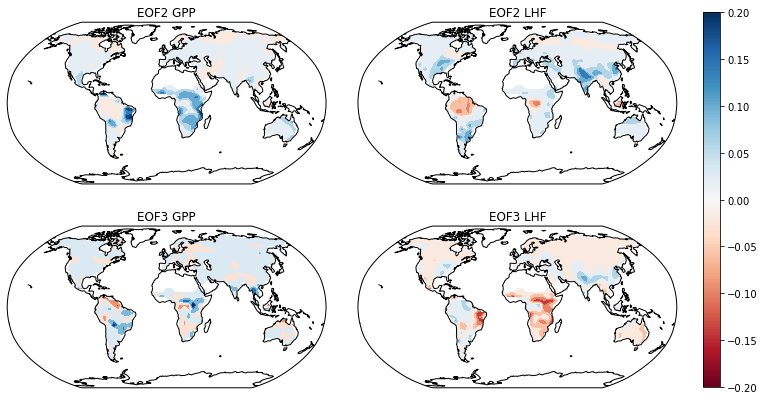

In [237]:
j = 1 # mode 2
fig, axs = plt.subplots(2, nvar, figsize=(12, 10), subplot_kw={'projection': ccrs.Robinson()})
axs = axs.ravel()

Vhmap_mode = Vhmap_GPP[j]
field, lon = add_cyclic_point(Vhmap_mode, coord=Vhmap_mode.lon)
lat = Vhmap_mode.lat
cf = axs[0].contourf(lon, lat, field, cmap='RdBu',transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2)
axs[0].coastlines()
axs[0].set_global()
axs[0].set_title('EOF'+str(j+1)+' GPP')

Vhmap_mode = Vhmap_LHF[j]
field, lon = add_cyclic_point(Vhmap_mode, coord=Vhmap_mode.lon)
lat = Vhmap_mode.lat
cf = axs[1].contourf(lon, lat, field, cmap='RdBu',transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2)
axs[1].coastlines()
axs[1].set_global()
axs[1].set_title('EOF'+str(j+1)+' LHF')

j = 2 # mode 3
Vhmap_mode = Vhmap_GPP[j]
field, lon = add_cyclic_point(Vhmap_mode, coord=Vhmap_mode.lon)
lat = Vhmap_mode.lat
cf = axs[2].contourf(lon, lat, field, cmap='RdBu',transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2)
axs[2].coastlines()
axs[2].set_global()
axs[2].set_title('EOF'+str(j+1)+' GPP')

Vhmap_mode = Vhmap_LHF[j]
field, lon = add_cyclic_point(Vhmap_mode, coord=Vhmap_mode.lon)
lat = Vhmap_mode.lat
cf = axs[3].contourf(lon, lat, field, cmap='RdBu',transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2)
axs[3].coastlines()
axs[3].set_global()
axs[3].set_title('EOF'+str(j+1)+' LHF')

plt.subplots_adjust(hspace=-0.4,wspace=0.1)

cb_ax = fig.add_axes([0.93, 0.25, 0.02, 0.52])
cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm, orientation='vertical')

#plt.savefig("PPE_maps_EOF2-3_GPP_LHF.pdf")

Map plots of all three modes, both output variables \
Equal area, unweighted maps

In [243]:
Vhmaps = [Vhmap_GPP, Vhmap_LHF]

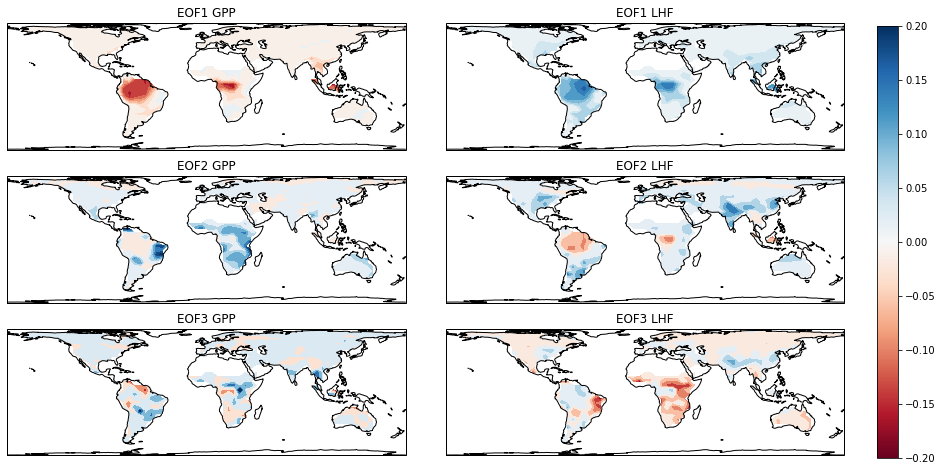

In [278]:
fig, axs = plt.subplots(nmodes, nvar, figsize=(15, 15), subplot_kw={'projection': ccrs.LambertCylindrical()})
for j in range(nmodes):
    for i in range(nvar):
        Vhmap_mode = Vhmaps[i][j]
        field, lon = add_cyclic_point(Vhmap_mode, coord=Vhmap_mode.lon)
        lat = Vhmap_mode.lat
        cf = axs[j,i].contourf(lon, lat, field, cmap='RdBu',transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2)
        axs[j,i].coastlines()
        axs[j,i].set_global()
        axs[j,i].set_title('EOF'+str(j+1)+' '+var[i])

plt.subplots_adjust(hspace=-0.7,wspace=0.1)

cb_ax = fig.add_axes([0.93, 0.3, 0.02, 0.4])
cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm, orientation='vertical')

#plt.savefig("PPE_maps_EOF1-3_GPP_LHF.pdf")

Panel plot with all distributions

In [280]:
Uvectors = [U_GPP, U_LHF]

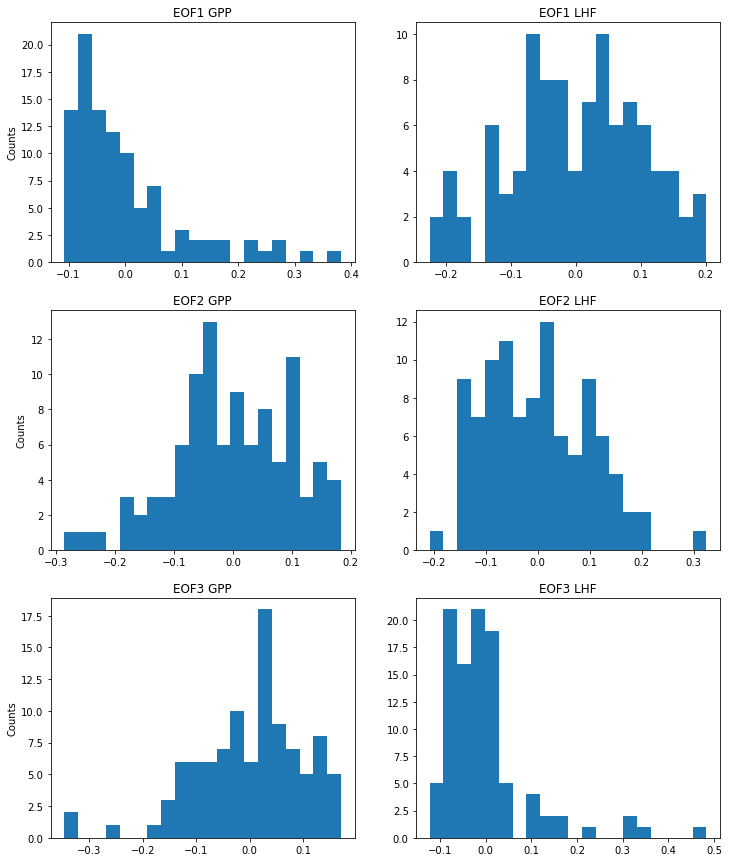

In [292]:
fig, axs = plt.subplots(nmodes, nvar, figsize=(6*nvar, 5*nmodes))
for j in range(nmodes):
    for i in range(nvar):
        axs[j,i].hist(Uvectors[i][:,j], bins=20)
        axs[j,i].set_title("EOF"+str(j+1)+" "+var[i])
        if i == 0:
            axs[j,i].set_ylabel("Counts");
            
#plt.savefig("PPE_dists_EOF1-3_GPP_LHF.pdf")